# FigureFluoremaxbeads 2024

This plots older data- Jan 2024 acquisition of multicolor fluorescent beads

## Imports

In [1]:
import matplotlib.font_manager
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

In [1]:
import matplotlib.pyplot as plt
from cleanplots import *

import numpy as np
import torch
import torchvision
import os
import sys
sys.path.append("../") # needed to bring in sdc module
import sdc_config as sdc
import jax.numpy as jnp
import jax
# figures helper functions
%run figures_util.py


# stop jax from taking over gpu memory
os.environ[“XLA_PYTHON_CLIENT_PREALLOCATE”] = “false”
os.environ[“XLA_PYTHON_CLIENT_ALLOCATOR”] = “platform”
os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true”

## System parameters

In [16]:
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 2
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)
objective = 4 # 4x objective
mag_size = objective*9/39 # 4x followed by diffuser F=9mm and relay lens f=39mm
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
gt_pixel_size = 1.67 # um # oldest gt camera -
gt_mag_size = objective*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um


## Plot green cells

/tmp/ipykernel_1838844/2197090548.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xk = torch.load(os.path.join(datafolder, file), map_location = 'cpu')
Clipping input da

Bead 1 - X: 292, Y: 311
Bead 2 - X: 324, Y: 271


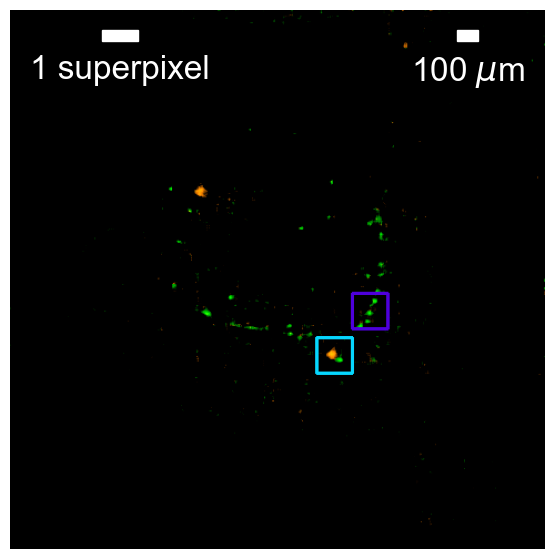

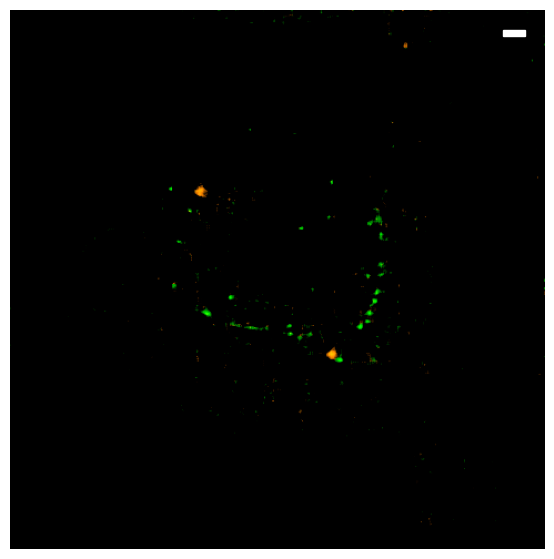

In [17]:
datafolder = '../Results/FOM2024'
file = 'multicolor_10umgreen_30umorange_low_rank_filter_new_vis.pt'

xk = torch.load(os.path.join(datafolder, file), map_location = 'cpu')
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
skip =[]#  [0,1]#[0,3]

bead_locations, recon_annotated = findbeadsinimage(false_color, 50, skip = skip ,maxnum = 2, label_bead = False)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(recon_annotated**1.8*2)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")

    # Display the image 
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(false_color**1.8*2)
plt.axis('off')
# ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'upper right', size_vertical=5)
ax.add_artist(scalebarum)


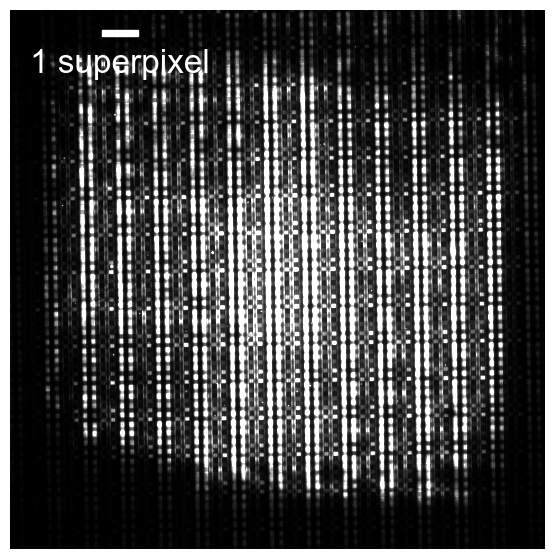

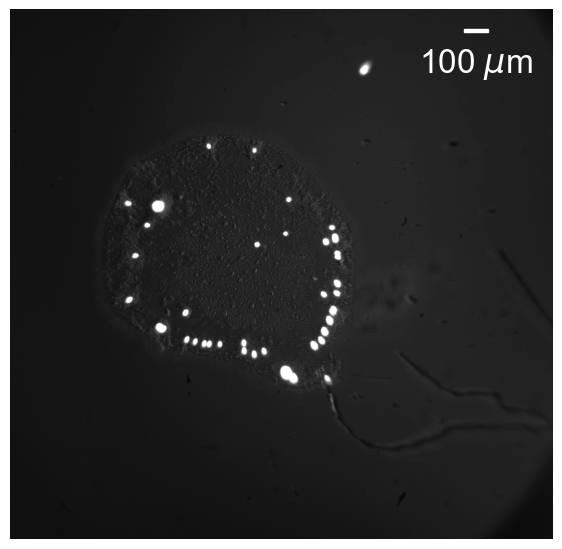

In [18]:
# crop_indices = [420,1852,1150,2826] #top bottom left default: [320,1652,1350,2726]
crop_indices = [680,1652,1600,2564]

datafolder = '/media/azuldata/neerja/2024-01-30/multicolor_10umgreen_30umorange'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'

bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement, cmap='gray')
# plt.colorbar()  
plt.clim([0,.1])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size)
ax.add_artist(scalebar)

# draw groundtruth
gt_name = 'gt.tiff'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
gt_rot = ndimage.rotate(gt, -90, reshape=True)

fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot,cmap='gray')
plt.axis('off')
plt.ylim([2300,300])
scalebar = drawscalebar(ax, 100,gt_pixel_size,mag = gt_mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebar)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


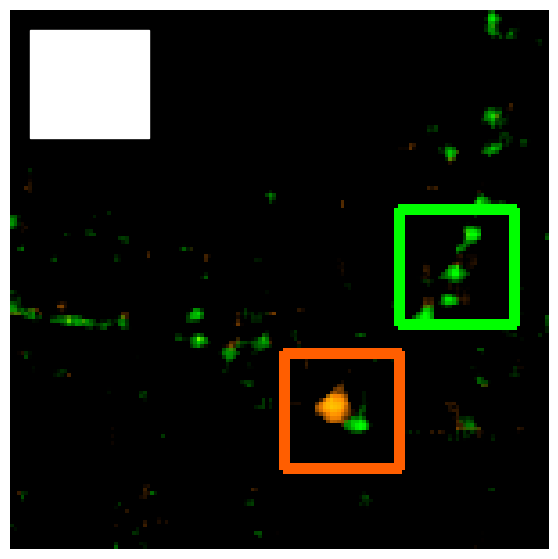

In [19]:
zoom = false_color[200:350,200:350,:]
white = (255,255,255)
green = (0,255,0)
orange = (0,100,255)
use_colors = [orange,green]

zoom_bead_locations, zoom_annotated = findbeadsinimage(zoom, 50, skip = skip ,maxnum = 2, label_bead = False, colindices = [0,1], use_colors = use_colors)
    # Display the image 
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size, size_vertical = 30, scalebarname= '')
plt.imshow(zoom_annotated**1.8*2)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
# ax.add_artist(scalebarum)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


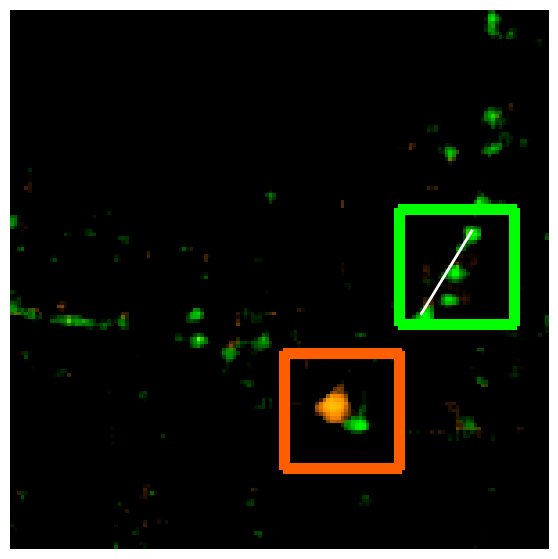

In [20]:
# make plot interactive
%matplotlib inline
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(zoom_annotated**1.8*2)
plt.axis('off')
from skimage.draw import line

pt1 = [84,114]
pt2 = [61,128]
# draw a line from pt 1 to pt 2
plt.plot([pt1[1],pt2[1]],[pt1[0],pt2[0]],color = 'white', linewidth = 2)
# get all the pixels that intersect the line
# Use skimage to find the pixels that intersect the line
rr, cc = line(pt1[0], pt1[1], pt2[0], pt2[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


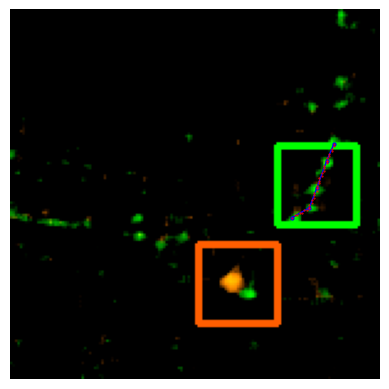

In [21]:
# Define the points
points = np.array([[84, 114], [80,121], [72,124], [61, 128], [54, 131]])
# Extract x and y coordinates
x = points[:, 1]
y = points[:, 0]

plt.imshow(zoom_annotated**1.8*2)

plt.plot(x, y, 'bo-', label='Piecewise Lines', linewidth=1, markersize=2)
# 
# get all the pixels that intersect the line
# Use skimage to find the pixels that intersect the line
# Collect all the pixels that intersect the lines

from skimage.draw import line

intersecting_pixels = np.ones((1,2))
for i in range(len(points) - 1):
    rr, cc = line(points[i][0], points[i][1], points[i+1][0], points[i+1][1])
    rc_stack = np.stack((rr, cc), axis=1)
    intersecting_pixels = np.vstack((intersecting_pixels,rc_stack))
    plt.plot(cc, rr, 'r.', markersize=1)  # Plot the intersecting pixels on the image

plt.axis('off')
plt.show()

In [9]:
# plot total intensity along the line
pixyx = intersecting_pixels+200
pixyx.shape
xk_white = xk.sum(axis = 2)
cross_line = xk_white[pixyx[:,0],pixyx[:,1]] 
plt.plot(cross_line)

TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value [201. 284. 283. 283. 282. 282. 281. 281. 280. 280. 279. 278. 277. 276.
 275. 274. 273. 272. 272. 271. 270. 269. 268. 267. 266. 265. 264. 263.
 262. 261. 261. 260. 259. 258. 257. 256. 255. 254.]

In [40]:
xk_white = xk.sum(axis = 2)
cross_line = xk_white[pixyx[:,0],pixyx[:,1]] 

4

## Import ground truth spectra

['#Thorlabs FTS']
['#Thorlabs FTS']
1207
450.0450134
2728
799.9866333


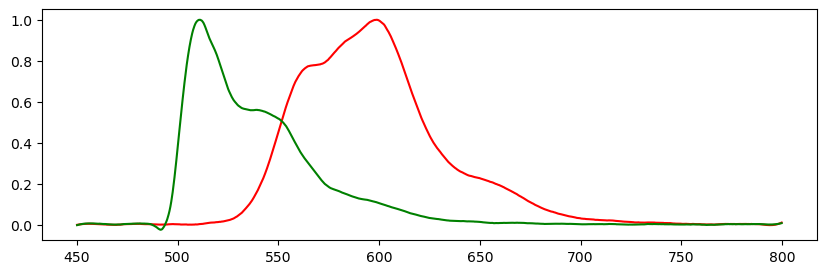

In [10]:
#import ground truth spectra 

green_beads = '/media/azuldata/neerja/2022-04-08/greenbeads_oldslide_emissionspectra.csv'
red_beads = '/media/azuldata/neerja/2022-04-08/redbeads_fresh_emissionspectra.csv'
import csv
file = open(green_beads)
csvreader = csv.reader(file)
header = next(csvreader)
print(header)
rows = []
for row in csvreader:
#     print(row)
    rows.append(row)
file.close()
green_spec = rows[32:-1]
g_wavelength = []
g_intensity = []
for ii in green_spec:
    vals = ii[0].split(';')
    g_wavelength.append(float(vals[0]))
    g_intensity.append(float(vals[1]))

file = open(red_beads)
csvreader = csv.reader(file)
header = next(csvreader)
print(header)
rows = []
for row in csvreader:
#     print(row)
    rows.append(row)
file.close()
green_spec = rows[32:-1]
r_wavelength = []
r_intensity = []
for ii in green_spec:
    vals = ii[0].split(';')
    r_wavelength.append(float(vals[0]))
    r_intensity.append(float(vals[1]))

    # cut to wvnew and filter and normalize
from scipy.signal import savgol_filter

rwv = np.array(r_wavelength)
idxmin = np.where(abs(rwv-wvmin) == np.amin(abs(rwv-wvmin)))[0][0]
idxmax = np.where(abs(rwv-wvmax) == np.amin(abs(rwv-wvmax)))[0][0]
print(idxmin)
print(rwv[idxmin])
print(idxmax)
print(rwv[idxmax])

rwvn = rwv[idxmin:idxmax]
rint = np.array(r_intensity)
rintn = savgol_filter(rint[idxmin:idxmax],91,3) #cut and filter
rintn = rintn/np.amax(rintn)

gwv = np.array(g_wavelength)
gint = np.array(g_intensity)
gwvn = gwv[idxmin:idxmax]
gintn = savgol_filter(gint[idxmin:idxmax],91,3) #cut and filter
gintn = gintn/np.amax(gintn)

plt.figure(figsize = (10,3))
plt.plot(rwvn,rintn,'r')
plt.plot(gwvn,gintn,'g')

## Plot spectra

[(292, 311), (324, 271)]


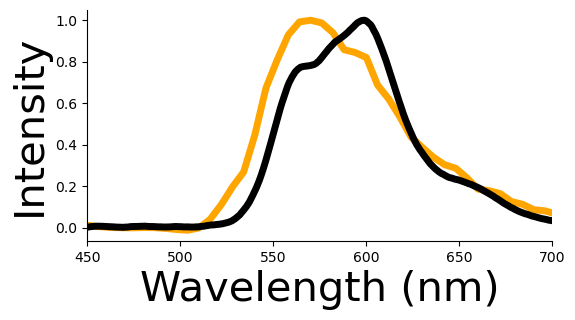

In [11]:
print(bead_locations)
orange_bead = xk[:,bead_locations[0][1],bead_locations[0][0]]
orange_bead = orange_bead/np.amax(orange_bead)
orange_bead_fil = savgol_filter(orange_bead,10,3)
orange_bead_fil = orange_bead_fil/np.amax(orange_bead_fil)

plt.figure(figsize = (6,3))
# plt.plot(wavelengths, orange_bead, color='orange', linewidth=2.5)
plt.plot(wavelengths, orange_bead_fil, color='orange', linewidth=5)

plt.xlabel('Wavelength (nm)', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.xlim([450,700])
plt.plot(rwvn,rintn,'k', linewidth=5)
# plt.plot(wavelengths_gt, spectra_gt[:,1],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

[(292, 311), (324, 271)]


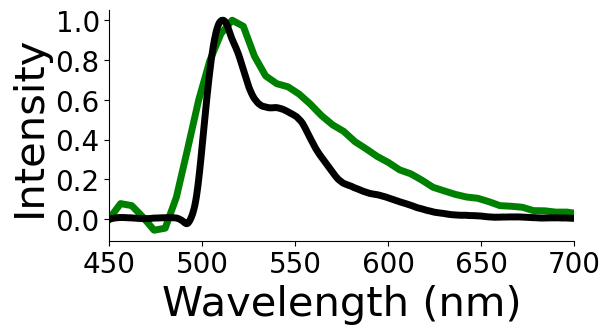

In [12]:
print(bead_locations)
green_bead = xk[:,bead_locations[1][1],bead_locations[1][0]]
green_bead = green_bead/np.amax(green_bead)
green_bead_fil = savgol_filter(green_bead,10,3)  # note spectral filtering
green_bead_fil = green_bead_fil/np.amax(green_bead_fil)

plt.figure(figsize = (6,3))
# plt.plot(wavelengths, orange_bead, color='orange', linewidth=2.5)
plt.plot(wavelengths, green_bead_fil, color='green', linewidth=5)

plt.xlabel('Wavelength (nm)', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([450,700])
plt.plot(gwvn,gintn,'k', linewidth=5)
# plt.plot(wavelengths_gt, spectra_gt[:,1],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## try on newer data